In [1]:
# working with directories
import os

# working with numbers
import pandas as pd
import numpy as np
from tqdm import tqdm

# sci-kit learn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# For model building and dfing
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

# reading images
from PIL import Image

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook_connected"

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
weather_dict = {}
for wc in os.listdir("Dataset"):
    for wi in os.listdir(f"Dataset/{wc}"):
        weather_dict[wi] = wc

In [3]:
# set up a dataframe and get image names and respective weathers
df = pd.DataFrame.from_dict(weather_dict, orient='index')
df.reset_index(inplace=True)
df.columns = ['img_name', 'weather']
df = df.loc[:, ['weather', 'img_name']]

# get image paths
df['path'] = 'Dataset/'+df.weather + '/' + df.img_name

# get image resolutions
df['resolution'] = [Image.open(path).size for path in tqdm(df.path)]

# split resolution in width and height columns
df['width'] = df.resolution.str[0]
df['height'] = df.resolution.str[1]

df.sample(10)

100%|██████████| 6737/6737 [00:03<00:00, 1736.56it/s]


weather  img_name                        path   resolution  width  \
5096       rime  5637.jpg       Dataset/rime/5637.jpg   (426, 240)    426   
4594       rime  5135.jpg       Dataset/rime/5135.jpg   (400, 257)    400   
6702       snow  1405.jpg       Dataset/snow/1405.jpg   (791, 337)    791   
5949  sandstorm  3308.jpg  Dataset/sandstorm/3308.jpg   (400, 300)    400   
6240  sandstorm  3599.jpg  Dataset/sandstorm/3599.jpg   (453, 240)    453   
4379    rainbow  0814.jpg    Dataset/rainbow/0814.jpg   (932, 638)    932   
2933       hail  0270.jpg       Dataset/hail/0270.jpg   (650, 413)    650   
4653       rime  5194.jpg       Dataset/rime/5194.jpg   (783, 382)    783   
214         dew  2422.jpg        Dataset/dew/2422.jpg  (1024, 680)   1024   
3633       snow  1017.jpg       Dataset/snow/1017.jpg   (427, 240)    427   

      height  
5096     240  
4594     257  
6702     337  
5949     300  
6240     240  
4379     638  
2933     413  
4653     382  
214      680  
3633     240

In [4]:
# Check if all the images have the same extension
df.img_name.str.split('.').str[1].unique()

array(['jpg'], dtype=object)

In [5]:
grouped = df.groupby('weather')['img_name'].count().to_frame()
grouped.reset_index(inplace=True)
grouped.columns = ['Weather', 'Count']

In [6]:
fig = px.bar(grouped, x='Weather', y='Count', 
             title='<b>Number of images by each weather category</b>', 
             color='Count') 

fig.update_layout(
    font_family="Courier New, monospace",
    font_size=12,
    font_color="#0c8df5",
    title_font_color="#0c8df5",
    title_font_family="Courier New, monospace",
)

fig.show()

In [7]:
# define function to plot images
def image_plots(df, nrows, ncols, width, height, show_resolution=False):
    # create the figure
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(width, height))
    fig.tight_layout()
    
    # flatten axs so that we can easily access their indices
    axs = axs.flatten()

    # plot images
    for i, idx in enumerate(df.index):
        if i>nrows*ncols-1:
            break
        axs[i].imshow(Image.open(df.loc[idx, 'path']))
        if show_resolution==True:
            axs[i].set(title=f"{df.loc[idx, 'weather'].title()}: {df.loc[idx, 'resolution']}")
            axs[i].axis('off')
        else:
            axs[i].set(title=df.loc[idx, 'weather'].title())
            axs[i].axis('off')

    # Remove empty subplot
    for ax in axs.flat[df.shape[0]:]:
        ax.remove()

    plt.show;

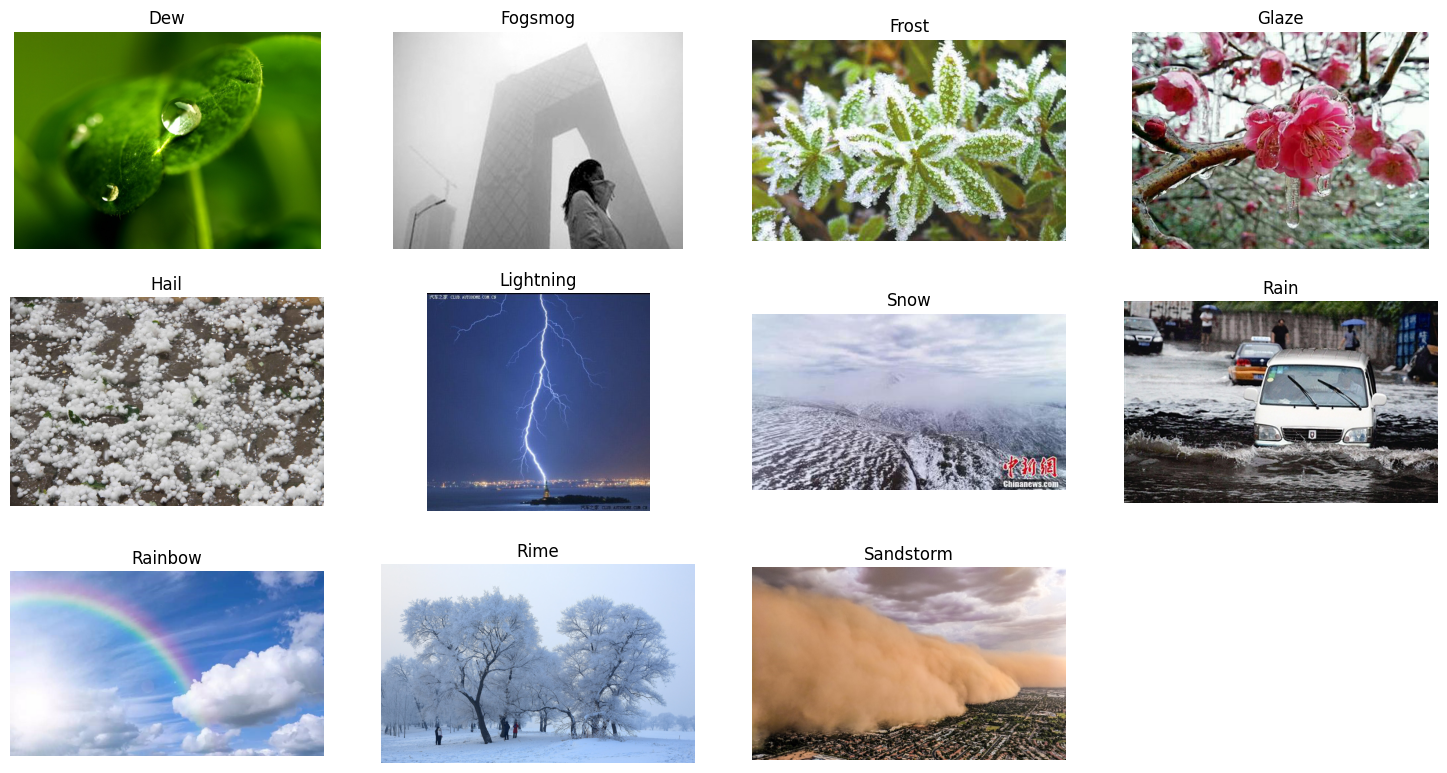

In [8]:
# get df of images we want to plot
images = df.groupby('weather').head(1)

image_plots(images, 3, 4, 15, 8)

<p style="background-color:#000099;color:white;font-style:italic;">As it looks like even the images in this small sample have different resolutions. Let's plot all resolutions to get some idea and later we will resize these images to one size to train CNN model.</p>

In [9]:
fig = px.scatter(df, x='width', y='height', 
             title='<b>Image resolutions</b>', 
             color='width')

fig['layout'].update(height=600)

fig.show()

In [10]:
fig = make_subplots(
    rows=2, 
    cols=2,
    vertical_spacing = 0.1,
    horizontal_spacing = 0.1,
    subplot_titles=(
        "Width Distribution",
        "Height Distribution",
        )
)

# Figure 1
fig.add_trace(
    go.Histogram(
        x=df.width,
        showlegend=False
    ),
    row=1,
    col=1
)

fig['layout']['xaxis1']['title']='Width'
fig['layout']['yaxis1']['title']='Count'

# figure 2
fig.add_trace(
    go.Histogram(
        x=df.height,
        showlegend=False
    ),
    row=1,
    col=2
)

fig['layout']['xaxis2']['title']='Height'
fig['layout']['yaxis2']['title']='Count'

# figure 3
fig.add_trace(
    go.Box(
        y = df.width,
        name='',
        marker_color='#0c8df5',
        boxmean=True,
        showlegend=False
    ), 
    row=2, 
    col=1
)

fig['layout']['yaxis3']['title']='Width'

# figure 4
fig.add_trace(
    go.Box(
        y = df.height,
        name='',
        marker_color='#0c8df5',
        boxmean=True,
        showlegend=False
    ), 
    row=2, 
    col=2
)

fig['layout']['yaxis4']['title']='Height'
fig['layout'].update(height=1000, title='<b>Stacked Subplots with Shared X-Axes</b>')


fig.show()

<p style="background-color:#000099;color:white;font-style:italic;">If we zoom and check distribution and box plots we can see that there are some outliers, for width they are outside both upper and lower fences, and for height they are above upper fence. We need to take a look at images with outliers. Considering the graphs we can try rescaling images to median or 3rd quartile/mean (these two are almost same) of width and height.</p>

In [11]:
w_upper_fence, w_lower_fence = 650, 250
h_upper_fence, h_lower_fence = 616, 91

outliers_df = df.loc[
    (df['width']>w_upper_fence) | \
    (df['width']<w_lower_fence) | \
    (df['height']>h_upper_fence) | \
    (df['height']<h_upper_fence)
    ]

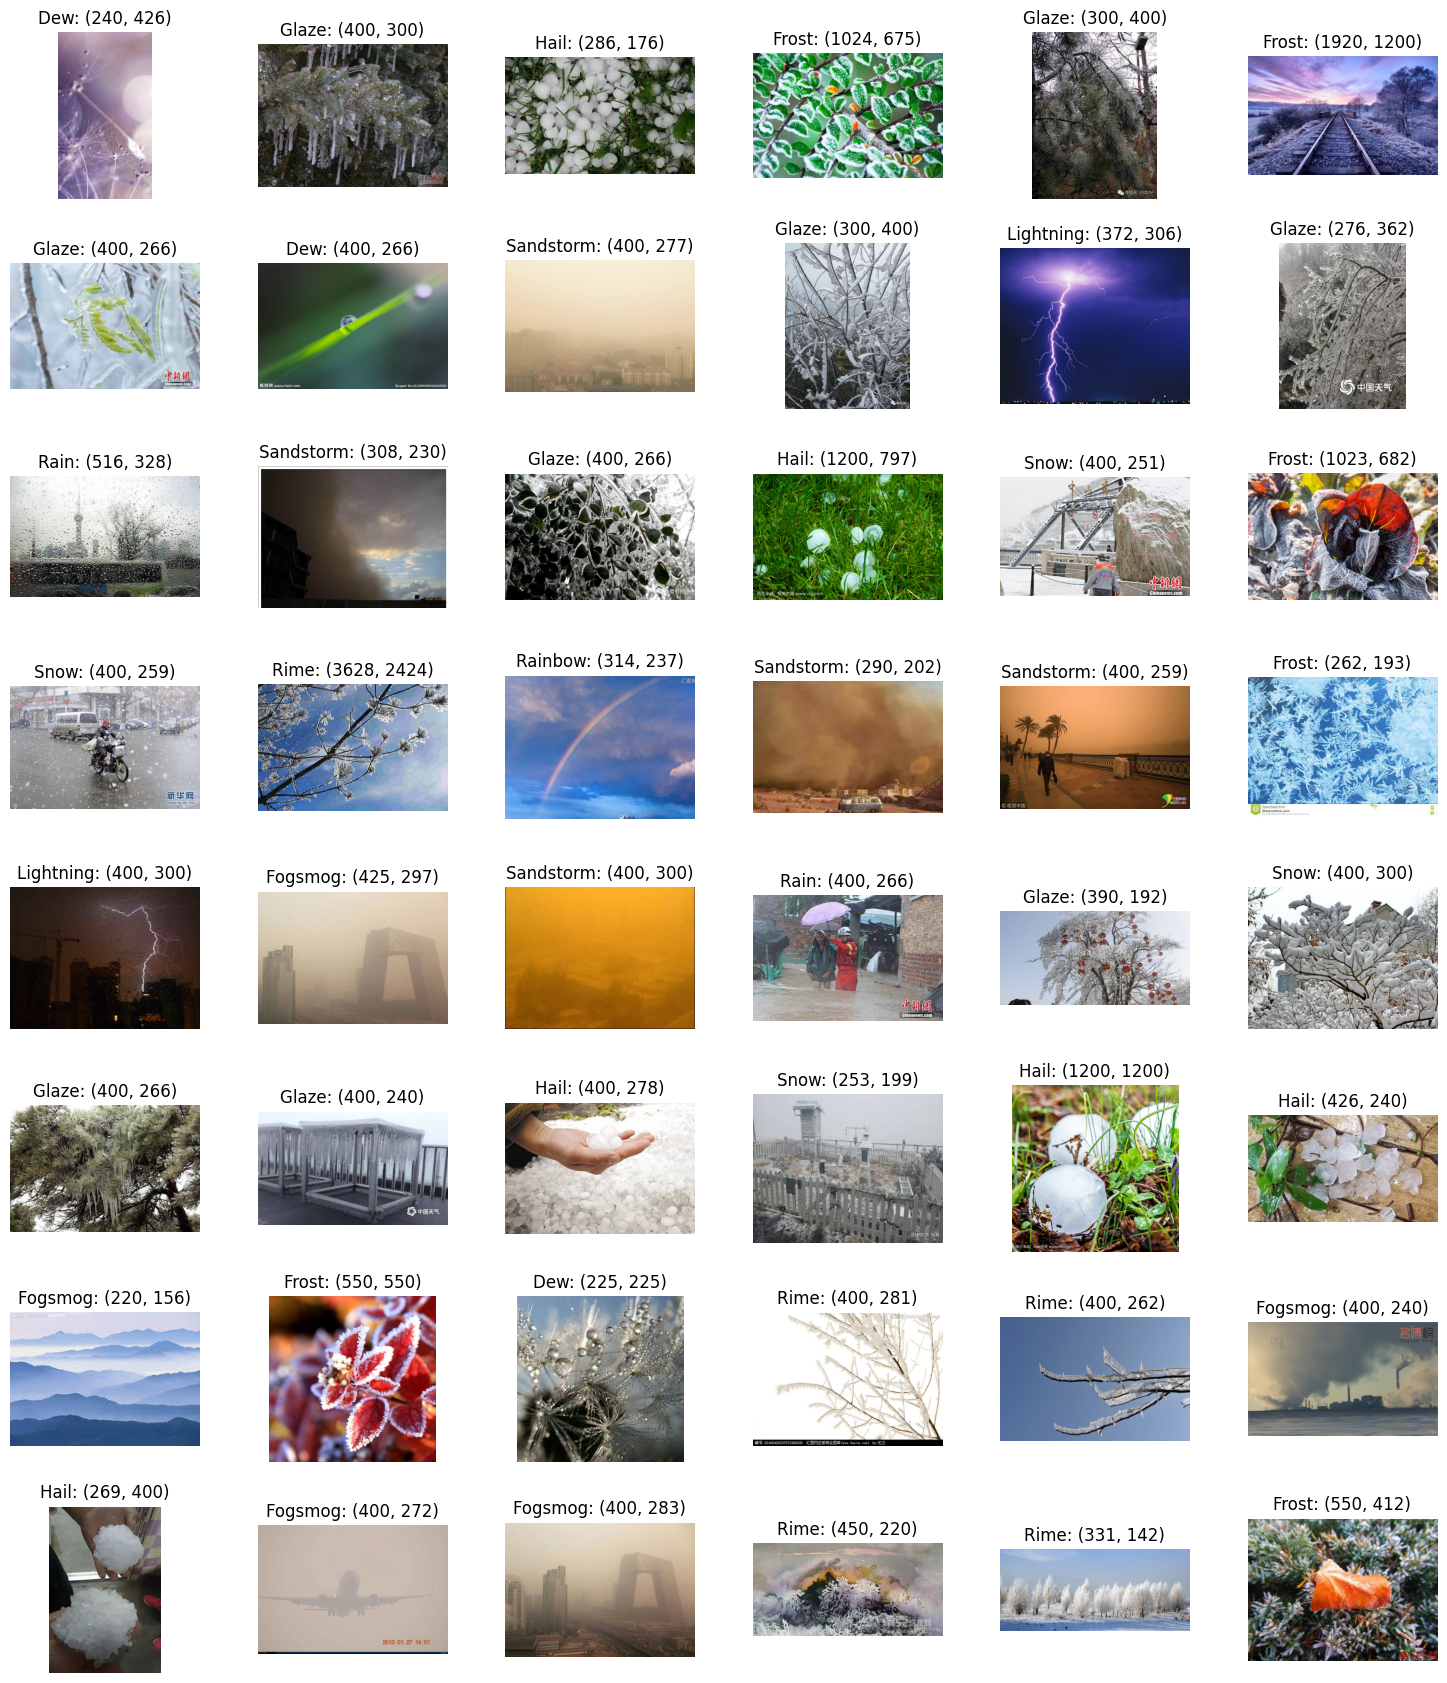

In [12]:
# get random sample of these outliers
outliers = outliers_df.sample(50, random_state=42)

# plot them
image_plots(outliers, 8, 6, 15, 17, True)

<p style="background-color:#000099;color:white;font-style:italic;font-weight:bold">Nothing looks weird with these outliers, they are indeed weather images. Therefore we can rescale them with pillow and use in our model.</p>

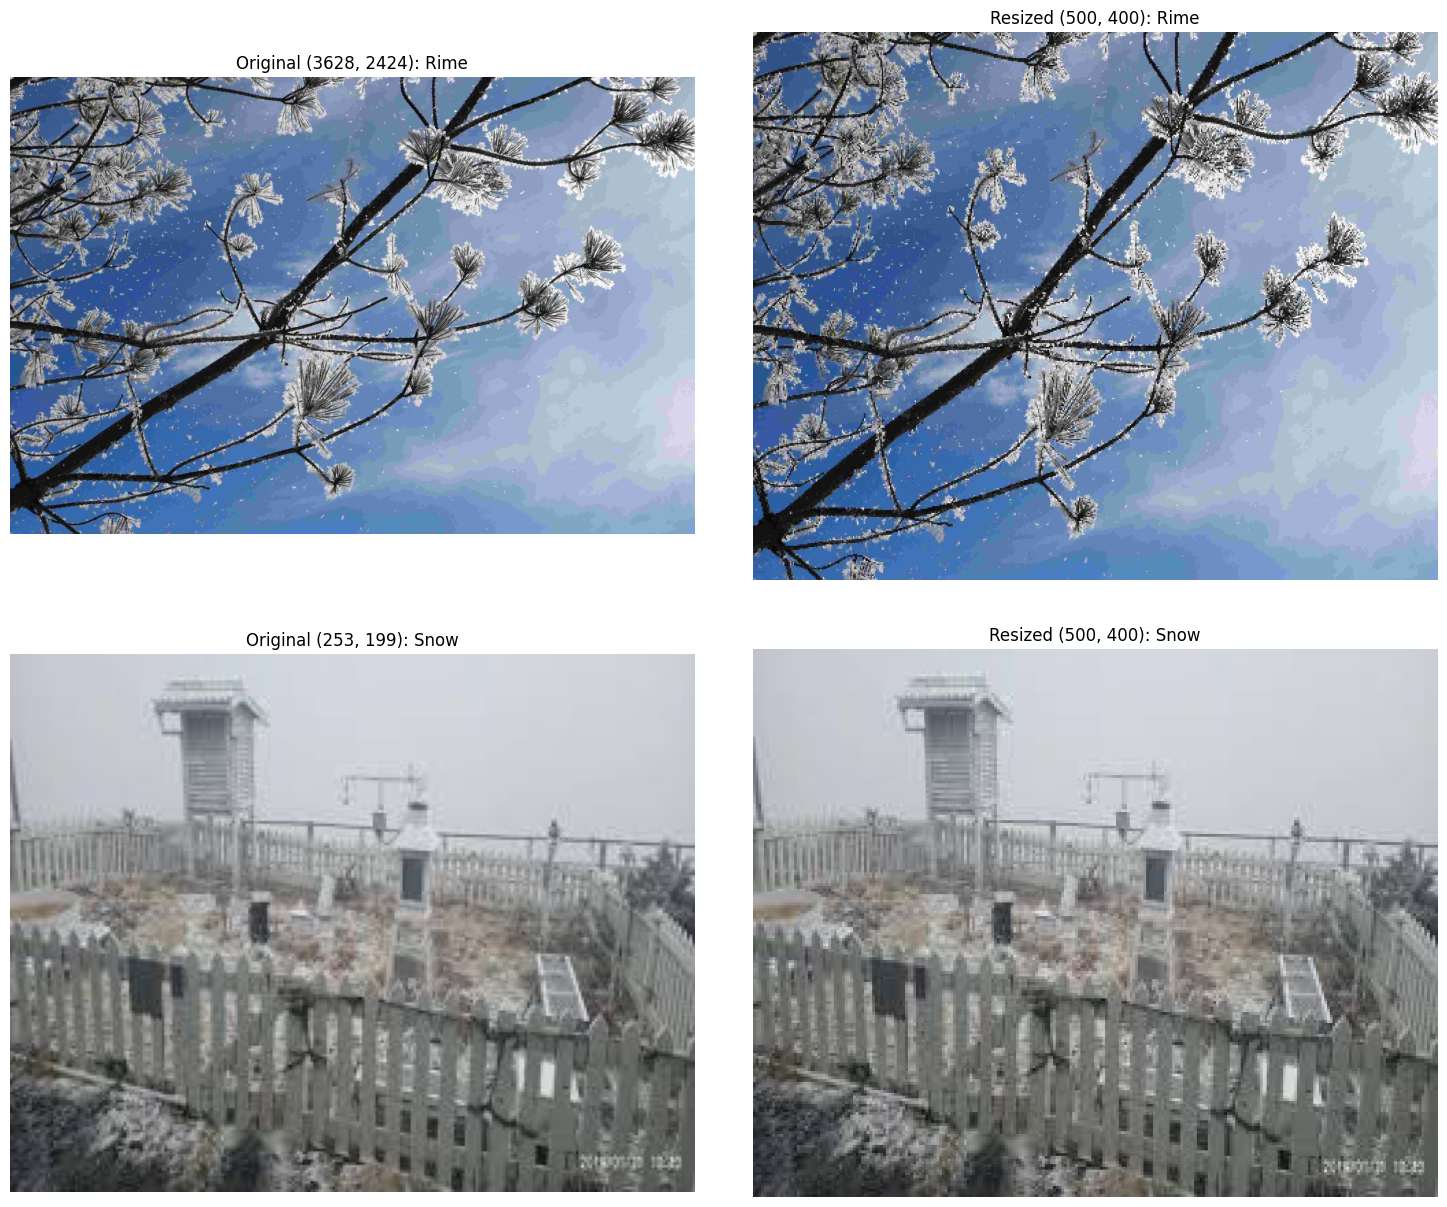

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
fig.tight_layout()
ax = ax.flatten()

ax[0].imshow(Image.open('Dataset/rime/5425.jpg'))
ax[0].set_title('Original (3628, 2424): Rime')
ax[0].axis('off')

ax[1].imshow(Image.open('Dataset/rime/5425.jpg').resize((500, 400), Image.NEAREST))
ax[1].set_title('Resized (500, 400): Rime')
ax[1].axis('off')

ax[2].imshow(Image.open('Dataset/snow/0900.jpg'))
ax[2].set_title('Original (253, 199): Snow')
ax[2].axis('off')

ax[3].imshow(Image.open('Dataset/snow/0900.jpg').resize((500, 400), Image.NEAREST))
ax[3].set_title('Resized (500, 400): Snow')
ax[3].axis('off')

fig.subplots_adjust(hspace=-0.25)

plt.show;

In [14]:
for idx in df.head(20).index:
    img = Image.open(df.loc[idx, 'path'])
    print(np.asarray(img).shape)

(675, 950, 3)
(578, 871, 3)
(564, 806, 3)
(797, 1200, 3)
(592, 947, 3)
(411, 500, 3)
(518, 777, 3)
(500, 800, 3)
(750, 500, 3)
(500, 752, 3)
(516, 688, 3)
(266, 400, 3)
(540, 720, 3)
(700, 1000, 3)
(398, 650, 3)
(348, 400, 3)
(678, 1024, 3)
(94, 150, 3)
(848, 1024, 3)
(266, 400, 3)


In [15]:
shape = df.path.apply(lambda x: np.asarray(Image.open(x)).shape)

In [16]:
df['img_shape'] = shape

In [17]:
df.loc[df.img_shape.str[2]!=3]

weather  img_name                   path  resolution  width  height  \
225      dew  2433.jpg   Dataset/dew/2433.jpg  (385, 240)    385     240   
258      dew  2466.jpg   Dataset/dew/2466.jpg  (400, 229)    400     229   
387      dew  2595.jpg   Dataset/dew/2595.jpg  (385, 240)    385     240   
395      dew  2603.jpg   Dataset/dew/2603.jpg  (385, 240)    385     240   
396      dew  2604.jpg   Dataset/dew/2604.jpg  (400, 229)    400     229   
...      ...       ...                    ...         ...    ...     ...   
6455    snow  1055.jpg  Dataset/snow/1055.jpg  (421, 240)    421     240   
6464    snow  1068.jpg  Dataset/snow/1068.jpg  (384, 240)    384     240   
6481    snow  1093.jpg  Dataset/snow/1093.jpg  (400, 290)    400     290   
6547    snow  1187.jpg  Dataset/snow/1187.jpg  (434, 300)    434     300   
6614    snow  1298.jpg  Dataset/snow/1298.jpg  (534, 379)    534     379   

          img_shape  
225      (240, 385)  
258      (229, 400)  
387   (240, 385, 4)  
395      (240, 385)  
396      (229, 400)  
...             ...  
6455  (240, 421, 4)  
6464  (240, 384, 4)  
6481  (290, 400, 4)  
6547     (300, 434)  
6614  (379, 534, 4)  

[171 rows x 7 columns]

In [18]:
np.asarray(Image.open('Dataset/dew/2595.jpg').convert('RGB')).shape

(240, 385, 3)

# Now let's Build Dataset and DataLoader

In [19]:
le = LabelEncoder()
target = le.fit_transform(df['weather'])
df['target'] = target

In [20]:
# Split the data in two
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=df.target)
test_df, valid_df = train_test_split(test_df, test_size=0.5, random_state=42, shuffle=df.target)

In [21]:
class WeatherDataset(Dataset):
    def __init__(self, path, target, size: tuple):
        self.tweet = size
        self.target = target
        self.path = path

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        img = Image.open(self.path[idx])
        img = img.convert('RGB').resize((500, 400), Image.NEAREST)
        img = torch.Tensor(np.asarray(img).reshape((3, 500, 400)))
        return img, torch.tensor(self.target[idx])

In [22]:
train_dataset = WeatherDataset(train_df.path.values, train_df.target.values, (500, 400))
valid_dataset = WeatherDataset(valid_df.path.values, valid_df.target.values, (500, 400))
test_dataset = WeatherDataset(test_df.path.values, test_df.target.values, (500, 400))

In [23]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

# Build CNN model

In [24]:
class LeNet(nn.Module):
	def __init__(self, numChannels, classes):
		# call the parent constructor
		super(LeNet, self).__init__()
		# initialize first set of CONV => RELU => POOL layers
		self.conv1 = nn.Conv2d(in_channels=numChannels, out_channels=20, kernel_size=(5, 5))
		self.relu1 = nn.ReLU()
		self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		# initialize second set of CONV => RELU => POOL layers
		self.conv2 = nn.Conv2d(in_channels=20, out_channels=50,
			kernel_size=(5, 5))
		self.relu2 = nn.ReLU()
		self.maxpool2 = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2))
		# initialize first (and only) set of FC => RELU layers
		self.fc1 = nn.Linear(in_features=591700, out_features=1024)
		self.relu3 = nn.ReLU()
		# initialize our softmax classifier
		self.fc2 = nn.Linear(in_features=1024, out_features=classes)
		self.logSoftmax = nn.LogSoftmax(dim=1)
	
	def forward(self, x):
		# pass the input through our first set of CONV => RELU =>
		# POOL layers
		x = self.conv1(x)  			# input(3x500x400), output(20x496x396)
		x = self.relu1(x)  			# input(20x496x396), output(20x496x396)
		x = self.maxpool1(x)		# input(20x496x396), output(20x249x199)
		# pass the output from the previous layer through the second
		# set of CONV => RELU => POOL layers
		x = self.conv2(x)			# input(20x249x199), output(50x245x195)
		x = self.relu2(x)			# input(50x245x195), output(50x245x195)
		x = self.maxpool2(x)		# input(50x245x195), output(50x122x97)
		# flatten the output from the previous layer and pass it
		# through our only set of FC => RELU layers
		x = torch.flatten(x, 1)           # input(50x122x97), output(591700)
		x = self.fc1(x)             # input(591700), output(1024)
		x = self.relu3(x)			# input(1024), output(1024)
		# pass the output to our softmax classifier to get our output
		# predictions
		x = self.fc2(x)				# input(1024), output(11)
		output = self.logSoftmax(x)
		# return the output predictions
		return output

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [26]:
model = LeNet(3, 11).to(device)
loss_criteria = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6, weight_decay=1e-4)

In [27]:
def training(model, data_loader):
    # Set the model to training mode
    model.train()
    train_loss = 0
    correct = 0
    
    pbar_batch = tqdm(position=0, leave=True, desc='Training', total = len(data_loader))
    pbar_batch.reset()
    
    for batch, (inputs, target) in enumerate(data_loader):
        inputs, target = inputs.to(device), target.to(device)
        
        #feedforward
        optimizer.zero_grad()
        output = model(inputs)
        loss = loss_criteria(output, target)
        train_loss += loss.item()
        
        # backpropagate
        loss.backward()
        optimizer.step()
        
        # Calculate the accuracy
        predicted = output.argmax(axis=1)
        correct += torch.sum(target==predicted).item()

        pbar_batch.update(1)
    
    # calculate total training accuracy for this epoch
    accuracy = correct / len(data_loader.dataset)*100
    
    #Return average loss
    avg_loss = train_loss / (batch+1)
    
    print(f'Training loss: {avg_loss:.4f}, \
          Training accuracy: {correct}/{len(data_loader.dataset)} ({accuracy:.3f}%)\n')
    return avg_loss, accuracy

In [28]:
def validation(model, data_loader):
    # Switch the model to evaluation mode (so we don't backpropagate)
    model.eval()
    valid_loss = 0
    correct = 0
    
    with torch.no_grad():
        for batch, (inputs, target) in enumerate(data_loader):
            inputs, target = inputs.to(device), target.to(device)
            
            # Get the predictions
            output = model(inputs)

            # calculate the loss
            loss = loss_criteria(output, target)
            valid_loss += loss.item()

            # Calculate the accuracy
            predicted = output.argmax(axis=1)
            correct += torch.sum(target==predicted).item()
                        
    # Calculate total accuracy for this epoch
    accuracy = correct/len(data_loader.dataset)*100

    avg_loss = valid_loss / (batch+1)
    print(f'Validation loss: {avg_loss:.4f}, \
          Validation Accuracy: {correct}/{len(data_loader.dataset)} ({accuracy:.3f}%)\n')
   
    # return average loss for the epoch
    return avg_loss, accuracy

In [29]:
# We'll track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
validation_loss = []
validation_accuracies = []
training_accuracies = []

epochs = 20
for epoch in range(1, epochs + 1):

    # print the epoch number
    print(f'Epoch: {epoch}')
    
    # Feed training data into the model to optimize the weights
    train_loss, train_accuracy = training(model, train_loader)
    
    # Feed the test data into the model to check its performance
    valid_loss, valid_accuracy = validation(model, valid_loader)
    
    # Log the metrics for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    training_accuracies.append(train_accuracy)
    validation_loss.append(valid_loss)
    validation_accuracies.append(valid_accuracy)

    # Save model after each epoch
    # torch.save({
    #             'epoch': epoch_nums,
    #             'model_state_dict': model.state_dict(),
    #             'optimizer_state_dict': optimizer.state_dict(),
    #             }, f'Models/model_{epoch}.pt')

Epoch: 1


Training:   0%|          | 0/169 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 290.00 MiB (GPU 0; 4.00 GiB total capacity; 3.15 GiB already allocated; 0 bytes free; 3.27 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF